# **Homework 1: COVID-19 Cases Prediction (Regression)**

訓練技巧0917

1. Data Cleaning
2. Loss function
3. Loss Function penalty(正則化L2)
4. Hyperameter modifications

＊＊這份原始code(baseline)在做normalization時有問題要重新寫＊＊


Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [ ]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 211MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 147MB/s]


# **Import Some Packages**

In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Cheryl0917 新增一些package來做 data cleaning, feature engineering
from sklearn.model_selection import train_test_split
import pandas as pd
import pprint as pp


myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Data Analysis

做特徵篩選強化數據集


In [ ]:
data_tr = pd.read_csv(tr_path)
data_tt = pd.read_csv(tt_path)

In [ ]:
data_tr.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [ ]:
data_tr.columns

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

ID col對於模型預測沒有幫助，所以可以拿掉

In [ ]:
data_tr.drop(['id'],axis = 1, inplace = True) #由于id列用不到，删除id列
data_tt.drop(['id'],axis = 1, inplace = True)

In [ ]:
#把特徵名稱提出來，作為後續feature engineering時可用的資料
cols = list(data_tr.columns)
pp.pprint(data_tr.columns)

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli',
       'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop',
       'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious',
       'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1',
       'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1',
       'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1',
       'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1',
       'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2',
       'nohh_cmnty_cli.2', 'wearing_m

In [ ]:
pp.pprint(data_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AL                      2700 non-null   float64
 1   AK                      2700 non-null   float64
 2   AZ                      2700 non-null   float64
 3   AR                      2700 non-null   float64
 4   CA                      2700 non-null   float64
 5   CO                      2700 non-null   float64
 6   CT                      2700 non-null   float64
 7   FL                      2700 non-null   float64
 8   GA                      2700 non-null   float64
 9   ID                      2700 non-null   float64
 10  IL                      2700 non-null   float64
 11  IN                      2700 non-null   float64
 12  IA                      2700 non-null   float64
 13  KS                      2700 non-null   float64
 14  KY                      2700 non-null   

In [ ]:
#從"state"之後的那個column開始取，因為state的資料之後會拿掉不使用
#col 39之後是從cli開始（covid-like illness）
data_tt.iloc[:,40:].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,...,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.972457,0.991809,29.075682,24.018729,89.637506,9.001325,31.620607,55.422982,16.554387,36.371653,...,55.268628,16.444916,36.165898,10.248975,2.369115,17.988147,12.993830,19.238723,64.619920,44.411505
std,0.411997,0.415468,9.596290,8.988245,4.733549,3.655616,4.754570,4.366780,5.688802,6.203232,...,4.350540,5.656828,6.192274,4.498845,1.114366,2.207022,1.713143,2.687435,5.685865,4.605268
min,0.139558,0.159477,9.171315,6.014740,76.895278,2.062500,18.299198,44.062442,3.800684,21.487077,...,44.671891,3.837441,21.338425,2.334655,0.873986,12.696977,8.462444,13.476209,50.212234,35.072577
25%,0.673327,0.689367,21.831730,17.385490,86.587475,7.055039,28.755178,51.726987,13.314242,31.427591,...,51.594301,13.391769,31.330469,6.802860,1.760374,16.406397,11.777101,17.197313,60.358203,40.910546
50%,0.925230,0.936610,28.183014,23.035749,90.123133,8.773243,31.826385,55.750887,17.100556,36.692799,...,55.490325,16.975410,36.213594,9.550393,2.146468,17.719760,12.805424,19.068658,65.148128,44.504010
75%,1.251219,1.267463,36.813772,31.141866,93.387952,10.452262,35.184926,59.185350,20.919961,41.265159,...,59.078475,20.584376,41.071035,13.372731,2.645314,19.423720,14.091551,21.205695,68.994309,47.172065
max,2.488967,2.522263,53.184067,48.142433,97.843221,26.598752,42.887263,63.979007,27.438286,53.513289,...,63.771097,27.362321,52.045373,23.305630,9.118302,27.003564,18.964157,26.007557,76.871053,56.442135


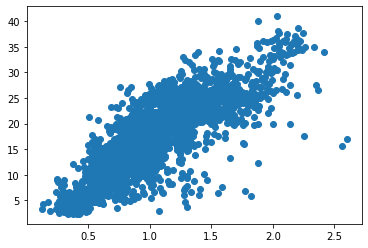

In [ ]:
#分析一下cli和target(tested-positive)之間的關係
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'tested_positive.2'])

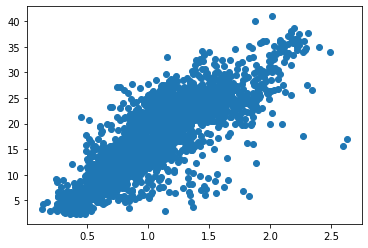

In [ ]:
plt.scatter(data_tr.loc[:, 'ili'], data_tr.loc[:, 'tested_positive.2'])

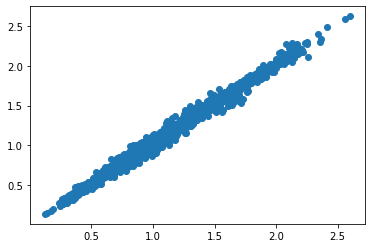

In [ ]:
#以上發現兩者特徵和tested_positive正相關
#後來觀察cli + ili發現兩這幾乎完全正相關，故取一個使用即可
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'ili'])

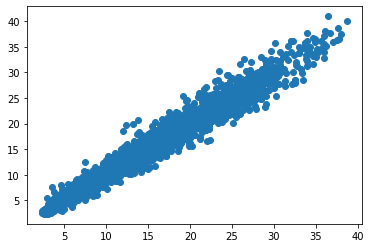

In [ ]:
#tested_positive是第一天確診人數，把他跟tested_positive.2第三天確診人數比較一下，發現正相關（第二天跟第三天也是）

plt.scatter(data_tr.loc[:,  'tested_positive'], data_tr.loc[:, 'tested_positive.2'])

In [ ]:
#更快速的方法，直接把所有features和target(第三天確診人數)做對比，用觀察correlation相關係數的方式
data_tr.iloc[:, 40:].corr() 

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,-0.107406,-0.095964,0.087305,-0.364165,-0.143318,-0.209020,...,-0.151291,-0.222834,-0.060308,-0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,-0.109015,-0.106934,0.086355,-0.357443,-0.142082,-0.207210,...,-0.150141,-0.220942,-0.061298,-0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,-0.035441,-0.069595,0.079219,-0.472746,-0.247043,-0.293775,...,-0.253615,-0.300062,-0.136937,-0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,-0.046063,-0.061914,0.097756,-0.465374,-0.238106,-0.280916,...,-0.245265,-0.287482,-0.129474,-0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,-0.107406,-0.109015,-0.035441,-0.046063,1.000000,-0.220808,-0.735649,-0.691597,-0.788714,-0.807623,...,-0.785281,-0.802659,-0.889021,0.133487,0.204031,-0.067720,0.427533,0.840528,0.340101,-0.069531
travel_outside_state,-0.095964,-0.106934,-0.069595,-0.061914,-0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,...,0.288098,0.336937,0.319736,-0.203611,0.001592,0.064425,-0.370776,-0.131961,-0.093096,-0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,-0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,...,0.730349,0.705533,0.758575,-0.110176,0.018259,0.075562,-0.430307,-0.652231,-0.317717,0.034865
shop,-0.364165,-0.357443,-0.472746,-0.465374,-0.691597,0.256911,0.631958,1.000000,0.820916,0.819035,...,0.811055,0.838358,0.787237,0.130046,-0.228007,-0.029168,-0.496368,-0.866789,-0.475304,-0.410430
restaurant,-0.143318,-0.142082,-0.247043,-0.238106,-0.788714,0.288473,0.743673,0.820916,1.000000,0.878576,...,0.993358,0.876107,0.909089,-0.046081,-0.278715,-0.074727,-0.648631,-0.832131,-0.430842,-0.157945
spent_time,-0.209020,-0.207210,-0.293775,-0.280916,-0.807623,0.349829,0.698047,0.819035,0.878576,1.000000,...,0.875365,0.986713,0.912682,-0.040623,-0.169965,0.105281,-0.517139,-0.867460,-0.522985,-0.252125


In [ ]:
data_corr = data_tr.iloc[:, 40:].corr()
target_col = data_corr['tested_positive.2'] #只印出最後一列，features和target的相關係數就好
target_col

cli                       0.838504
ili                       0.830527
hh_cmnty_cli              0.879724
nohh_cmnty_cli            0.869938
wearing_mask             -0.069531
travel_outside_state     -0.097303
work_outside_home         0.034865
shop                     -0.410430
restaurant               -0.157945
spent_time               -0.252125
large_event              -0.052473
public_transit           -0.448360
anxious                   0.173295
depressed                 0.037689
felt_isolated             0.082182
worried_become_ill        0.262211
worried_finances          0.475462
tested_positive           0.981165
cli.1                     0.838224
ili.1                     0.829200
hh_cmnty_cli.1            0.879438
nohh_cmnty_cli.1          0.869278
wearing_mask.1           -0.065600
travel_outside_state.1   -0.100407
work_outside_home.1       0.037930
shop.1                   -0.412705
restaurant.1             -0.159121
spent_time.1             -0.255714
large_event.1       

In [ ]:
feature = target_col[target_col > 0.8] #在最后一列相关性数据中选择大于0.8的行，这个0.8是自己设的超参，大家可以根据实际情况调节
feature

cli                  0.838504
ili                  0.830527
hh_cmnty_cli         0.879724
nohh_cmnty_cli       0.869938
tested_positive      0.981165
cli.1                0.838224
ili.1                0.829200
hh_cmnty_cli.1       0.879438
nohh_cmnty_cli.1     0.869278
tested_positive.1    0.991012
cli.2                0.835751
ili.2                0.826075
hh_cmnty_cli.2       0.878218
nohh_cmnty_cli.2     0.867535
tested_positive.2    1.000000
Name: tested_positive.2, dtype: float64

In [ ]:
feature_cols = feature.index.tolist()#把前面篩選出的高度相關特徵取出來
feature_cols.pop()#把我們的target(最後一列的tested_positive)拿掉，因為這不是我們要丟進機器裡的training data
pp.pprint(feature_cols)

['cli',
 'ili',
 'hh_cmnty_cli',
 'nohh_cmnty_cli',
 'tested_positive',
 'cli.1',
 'ili.1',
 'hh_cmnty_cli.1',
 'nohh_cmnty_cli.1',
 'tested_positive.1',
 'cli.2',
 'ili.2',
 'hh_cmnty_cli.2',
 'nohh_cmnty_cli.2']


In [ ]:
#以上已經提取特徵出來，但我們希望把特徵存取方式從“string"變成“int"方便後續做處理＋分析
feats_selected = [cols.index(col) for col in feature_cols]  
feats_selected

[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

# **Some Utilities**

You do not need to modify this part.

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [ ]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mu,      #mu,std是我自己加，baseline代码归一化有问题，我重写归一化部分
                 std,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:  #target_only 默认是false, 所以用的是全量特征，如果要用自己选择特征，则实例化这个类的时候，设置成True
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # TODO: Using 40 states & 4 tested_positive features (indices = 57 & 75)
            
            feats = list(range(40)) + feats_selected            # feats_selected是我们选择特征, 40代表是states特征
            
            #如果用只用两个特征，可以忽略前面数据分析过程,直接这样写
            #feats = list(range(40)) + [57, 75]
        
        if self.mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets  
#             if mode == 'train':
#                 indices = [i for i in range(len(data)) if i % 10 != 0]
#             elif mode == 'dev':
#                 indices = [i for i in range(len(data)) if i % 10 == 0]
            
            #baseline上面这段代码划分训练集和测试集按照顺序选择数据，可能造成数据分布问题，我改成随机选择
            indices_tr, indices_dev = train_test_split([i for i in range(data.shape[0])], test_size = 0.3, random_state = 0)
            if self.mode == 'train':
                indices = indices_tr
            elif self.mode == 'dev':
                indices = indices_dev
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        #self.data[:, 40:] = \
            #(self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            #/ self.data[:, 40:].std(dim=0, keepdim=True)
        #self.data = (self.data - self.data.mean(dim = 0, keepdim = True)) / self.data.std(dim=0, keepdim=True)
        
        #baseline这段代码数据归一化用的是当前数据归一化，事实上验证集上和测试集上归一化一般只能用过去数据即训练集上均值和方差进行归一化
        
        if self.mode == "train": #如果是训练集，均值和方差用自己数据
            self.mu = self.data[:, 40:].mean(dim=0, keepdim=True)
            self.std = self.data[:, 40:].std(dim=0, keepdim=True)
        else: #测试集和开发集，传进来的均值和方差是来自训练集保存，如何保存均值和方差，看数据dataload部分
            self.mu = mu
            self.std = std
            
        self.data[:,40:] = (self.data[:, 40:] - self.mu) / self.std  #归一化
        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [ ]:
#lass COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
 #   def __init__(self,
  #               path,
   #              mu, #mu,std是用來更改normalization的變數
    #             std,
    #              mode='train',
    #              target_only=False):
    #     self.mode = mode

    #     # Read data into numpy arrays
    #     with open(path, 'r') as fp:
    #         data = list(csv.reader(fp))
    #         data = np.array(data[1:])[:, 1:].astype(float)
        
    #     if not target_only:
    #         feats = list(range(93)) #這裡把所有特徵都用進去了，不是我們要的
    #     else:
    #         # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
    #         feats = list(range(40))+feats_selected
    #         #pass

    #     if mode == 'test':
    #         # Testing data
    #         # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
    #          data = data[:, feats]
    #          self.data = torch.FloatTensor(data)
    #     else:
    #         # Training data (train/dev sets)
    #         # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
    #          target = data[:, -1]
    #          data = data[:, feats]
            
    #         # Splitting training data into train & dev sets
    #         #這裡按順序慢慢劃分testing + validation,數據分佈問題會很嚴重，改成random split
    #        # if mode == 'train':
    #         #    indices = [i for i in range(len(data)) if i % 10 != 0]
    #        # elif mode == 'dev':
    #        #     indices = [i for i in range(len(data)) if i % 10 == 0]
            

    #          indices_tr, indices_dev = train_test_split([i for i in range(data.shape[0])],test_size = 0.3,random_state = 0)
            
    #          if self.mode == 'train':
    #              indices = indices_tr
    #          elif self.mode == 'dev':
    #              indices = indices_dev
            
    #         # Convert data into PyTorch tensors
    #          self.data = torch.FloatTensor(data[indices])
    #          self.target = torch.FloatTensor(target[indices])

    #     # Normalize features (you may remove this part to see what will happen)
    #     #原始的code是使用實時數據標準化，但原則上應該用歷史數據
    #    # self.data[:, 40:] = \
    #     #    (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
    #      #   / self.data[:, 40:].std(dim=0, keepdim=True)

    #          if self.mode == 'train':
    #             self.mu = self.data[:,40:].mean(dim = 0,keepdim = True)
    #             self.std = self.data[:,40:].std(dim = 0,keepdim = True)
    #          else:
    #           #如果不是training mode,那只好使用當時training時保存下來的歷史平均值和變異數
    #             self.mu = mu
    #             self.std = std
              
    #          self.data[:,40:] = (self.data[:, 40:] - self.mu) / self.std #normalization!
    #          self.dim = self.data.shape[1]

    #          print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
    #           .format(mode, len(self.data), self.dim))

    # def __getitem__(self, index):
    #     # Returns one sample at a time
    #     if self.mode in ['train', 'dev']:
    #         # For training
    #         return self.data[index], self.target[index]
    #     else:
    #         # For testing (no target)
    #         return self.data[index]

    # def __len__(self):
    #     # Returns the size of the dataset
    #     return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False,mu=None, std=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mu, std,mode=mode, target_only=target_only)  # Construct dataset
    if mode == 'train':  #如果是训练集，把训练集上均值和方差保存下来(在dataset function裡面算好的)
        mu = dataset.mu
        std = dataset.std
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader, mu, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 68),#這裡可以慢慢調參數看看linear 要多少層表現更好，嘗試68 & 70
            nn.ReLU(),
            nn.Linear(68, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        eps = 1e-6
        #L2_reg = 0
        Lambda = 0.0001
        #參考另一個大神的用L1正則試試看
        #lambda假設是0.0001
        l1 = 0
        for i in self.parameters():
            l1 += torch.sum(abs(i))
        #for name, w in self.net.named_parameters():
         #    if 'weight'  in name:
          #       l2_reg += alpha * torch.norm(w, p = 2).to(device)
        return torch.sqrt(self.criterion(pred, target)+eps)#+Lambda*l1

# **Train/Dev/Test**

## **Training**

In [ ]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [ ]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True #False改True,使用自己篩出來的特徵                  # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.005,      #0.001 -> 0.005           # learning rate of SGD
        'momentum': 0.5      #0.9->0.5        # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    #'save_path': 'models/model.pth'  # your model will be saved here
    'save_path': 'models/model_select.path'
}

# **Load data and model**

In [ ]:

tr_set, tr_mu, tr_std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set, mu_none, std_none = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, mu=tr_mu, std=tr_std)
tt_set, mu_none, std_none = prep_dataloader(tr_path, 'test', config['batch_size'], target_only=target_only, mu=tr_mu, std=tr_std)

Finished reading the train set of COVID19 Dataset (1890 samples found, each dim = 54)
Finished reading the dev set of COVID19 Dataset (810 samples found, each dim = 54)
Finished reading the test set of COVID19 Dataset (2700 samples found, each dim = 54)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.8756)
Saving model (epoch =    2, loss = 17.6954)
Saving model (epoch =    3, loss = 17.5014)
Saving model (epoch =    4, loss = 17.2829)
Saving model (epoch =    5, loss = 17.0278)
Saving model (epoch =    6, loss = 16.7225)
Saving model (epoch =    7, loss = 16.3470)
Saving model (epoch =    8, loss = 15.8856)
Saving model (epoch =    9, loss = 15.3223)
Saving model (epoch =   10, loss = 14.6299)
Saving model (epoch =   11, loss = 13.8034)
Saving model (epoch =   12, loss = 12.8730)
Saving model (epoch =   13, loss = 11.8917)
Saving model (epoch =   14, loss = 10.9599)
Saving model (epoch =   15, loss = 10.2306)
Saving model (epoch =   16, loss = 9.7266)
Saving model (epoch =   17, loss = 9.3949)
Saving model (epoch =   18, loss = 9.1542)
Saving model (epoch =   19, loss = 8.9452)
Saving model (epoch =   20, loss = 8.7482)
Saving model (epoch =   21, loss = 8.5583)
Saving model (epoch =   22, loss = 8.3705)
Saving model (epoch =   23, loss = 8.18

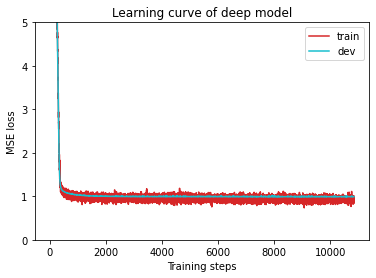

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

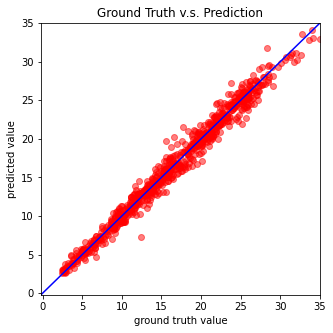

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
